# Import Packages

In [ ]:
# File handling
import pickle
import os

# Data handling
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model training
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model, load_model

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Connect to Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Connect to GPU

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

# # GPU found (colab)
# tf.device('/device:GPU:0')

## Move to data dir

In [ ]:
os.chdir('drive/MyDrive/BSA-data/')

# Read Pickle files

In [ ]:
dev_df = pickle.load(open('dev_df_processed.pkl','rb'))
test_df = pickle.load(open('test_df_processed.pkl','rb'))
train_df = pickle.load(open('train_df_processed1.pkl','rb')) # Using only top 3000 sentences

# train_df2 = pickle.load(open('train_df_processed2.pkl','rb'))
#
# train_df = pd.concat([train_df1,train_df2],ignore_index=True) # join both dfs
# del train_df1,train_df2

# Label encode Sentiment/Emotion

In [ ]:
# Helper Function
def Label_encode(df,e_col,s_col):
  # Create a LabelEncoder instance
  emotion_encoder = LabelEncoder()
  sentiment_encoder = LabelEncoder()

  # Fit and transform the column to label encode
  encoded_emotions = emotion_encoder.fit_transform(df[e_col])
  encoded_sentiments = sentiment_encoder.fit_transform(df[s_col])

  # Store the mappings of original labels and encoded values in a dictionary
  emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
  sentiment_mapping = dict(zip(sentiment_encoder.classes_, sentiment_encoder.transform(sentiment_encoder.classes_)))

  # Add encoded column to DataFrame
  df[s_col+"_encoded"] = encoded_sentiments
  df[e_col+"_encoded"] = encoded_emotions

  return df, emotion_mapping, sentiment_mapping

In [ ]:
s_col = 'Sentiment'
e_col = 'Emotion'

dev_df,emotion_mapping,sentiment_mapping = Label_encode(dev_df,e_col,s_col)
test_df,_,_ = Label_encode(test_df,e_col,s_col)
train_df,_,_= Label_encode(train_df,e_col,s_col)

print("Emotion Mapping: ",emotion_mapping)
print("Sentimnet Mapping: ",sentiment_mapping)

Emotion Mapping:  {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}
Sentimnet Mapping:  {'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
print(type(train_df['Emotion_encoded'][0]))
print(type(train_df['Sentiment_encoded'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>


### Make a table for num of emotions, sentiments per dataset

# Design Text-CNN Model

In [ ]:
# Hyperparameters
sentence_length = 350
embedding_dim = 300
num_filters = 100
filter_sizes = [3, 4, 5]
dropout_rate = 0.5

def create_model(num_classes):
  print("Creating Model...")

  # Input layer
  inputs = Input(shape=(sentence_length, embedding_dim))
  print(f"Input: {inputs.shape}")

  # Convolutional layers with different filter sizes
  conv_blocks = []
  for i in range(num_classes):

      block=[]
      for filter_size in filter_sizes:
          conv = tf.keras.layers.Conv1D(num_filters, filter_size, activation='relu')(inputs)
          pool = tf.keras.layers.GlobalMaxPooling1D()(conv)
          block.append(pool)

      # Concatenate outputs from different filter sizes
      conv_block = tf.keras.layers.Concatenate()(block)

      # Dense layer for feature learning
      dense = Dense(300, activation='tanh')(conv_block)

      print(f"Conv-block + Dense {i}: {conv_block.shape}, {dense.shape}")

      # Add dropout for regularization
      dropout = tf.keras.layers.Dropout(dropout_rate)(dense)

      # Join in a list
      conv_blocks.append(dropout)

  def stack(x):
        return tf.stack(x, axis=1)

  cnn_outputs = Lambda(stack)(conv_blocks) # Join all word layers into a sentence layer
  print("Sentence: ",cnn_outputs.shape)

  masked = Masking(mask_value =0)(cnn_outputs)
  print("Masked: ",masked.shape)

  lstm1 = Bidirectional(LSTM(300, activation='relu', return_sequences = True, dropout=0.3))(masked)
  print("LSTM1: ",lstm1.shape)

  lstm2 = Bidirectional(LSTM(300, activation='relu', return_sequences = False, dropout=0.3), name="utter")(lstm1)
  print("LSTM2: ",lstm2.shape)

  # Output layer
  outputs = Dense(num_classes,activation='softmax')(lstm2)
  print("Output: ",outputs.shape)

  # Create the model
  model = Model(inputs, outputs)
  return model



In [ ]:
sentiment_model = create_model(len(sentiment_mapping))
# Compile the model with appropriate loss and optimizer
sentiment_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

emotion_model = create_model(len(emotion_mapping))
# Compile the model with appropriate loss and optimizer
emotion_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Creating Model...
Input: (None, 350, 300)
Conv-block + Dense 0: (None, 300), (None, 300)
Conv-block + Dense 1: (None, 300), (None, 300)
Conv-block + Dense 2: (None, 300), (None, 300)
Sentence:  (None, 3, 300)
Masked:  (None, 3, 300)
LSTM1:  (None, 3, 600)
LSTM2:  (None, 600)
Output:  (None, 3)
Creating Model...
Input: (None, 350, 300)
Conv-block + Dense 0: (None, 300), (None, 300)
Conv-block + Dense 1: (None, 300), (None, 300)
Conv-block + Dense 2: (None, 300), (None, 300)
Conv-block + Dense 3: (None, 300), (None, 300)
Conv-block + Dense 4: (None, 300), (None, 300)
Conv-block + Dense 5: (None, 300), (None, 300)
Conv-block + Dense 6: (None, 300), (None, 300)
Sentence:  (None, 7, 300)
Masked:  (None, 7, 300)
LSTM1:  (None, 7, 600)
LSTM2:  (None, 600)
Output:  (None, 7)


# Train Model

In [ ]:
size = 1000

In [ ]:
def train_model(num_classes,model,epochs):
  if num_classes == len(sentiment_mapping): # sentiment model
    model_type = "Sentiment"
  elif num_classes == len(emotion_mapping): # emotion model
    model_type = "Emotion"
  else:
    return "Wrong number of classes"

  x_train = np.asarray(train_df['Word_embeddings'][:size].to_list())
  y_train = train_df[f'{model_type}_encoded'][:size].to_numpy()
  y_train = tf.one_hot(y_train,num_classes) # One hot encode each sentiment

  x_val = np.asarray(dev_df['Word_embeddings'][:size].to_list())
  y_val = dev_df[f'{model_type}_encoded'][:size].to_numpy()
  y_val = tf.one_hot(y_val,num_classes)

  # Train the model
  history = model.fit(x_train, y_train, epochs=epochs,verbose=1,validation_data=(x_val,y_val))

  return history

In [ ]:
# sentiment_hist = train_model(len(sentiment_mapping),sentiment_model,10)
print("\n\n")
emotion_hist = train_model(len(emotion_mapping),emotion_model,10)




Epoch 1/10
32/32 [==============================] - 176s 5s/step - loss: 1.5923 - accuracy: 0.4720 - val_loss: 1.6881 - val_accuracy: 0.4280
Epoch 2/10
32/32 [==============================] - 157s 5s/step - loss: 1.5302 - accuracy: 0.4790 - val_loss: 1.6358 - val_accuracy: 0.4280
Epoch 3/10
32/32 [==============================] - 147s 5s/step - loss: 1.4053 - accuracy: 0.4840 - val_loss: 1.6581 - val_accuracy: 0.4360
Epoch 4/10
32/32 [==============================] - 146s 5s/step - loss: 1.1325 - accuracy: 0.6030 - val_loss: 1.7904 - val_accuracy: 0.2540
Epoch 5/10
32/32 [==============================] - 136s 4s/step - loss: 0.9371 - accuracy: 0.6570 - val_loss: 1.9199 - val_accuracy: 0.4340
Epoch 6/10
32/32 [==============================] - 139s 4s/step - loss: 0.7279 - accuracy: 0.7440 - val_loss: 1.8372 - val_accuracy: 0.3830
Epoch 7/10
32/32 [==============================] - 139s 4s/step - loss: 0.4881 - accuracy: 0.8370 - val_loss: 2.1656 - val_accuracy: 0.3950
Epoch 8/10

# Evaluate models

In [ ]:
def evaluate_model(num_classes,model):
  if num_classes == len(sentiment_mapping): # sentiment model
    model_type = "Sentiment"
  elif num_classes == len(emotion_mapping): # emotion model
    model_type = "Emotion"
  else:
    return "Wrong number of classes"

  # Evaluate model
  x_test = np.asarray(test_df['Word_embeddings'][:size].to_list())
  y_test = test_df[f'{model_type}_encoded'][:size].to_numpy() # Add a word dimension
  y_test = tf.one_hot(y_test,num_classes)

  # Evaluate model
  loss, acc = model.evaluate(x_test,y_test)
  print(f"Loss: {loss}, Acc: {acc}")
  return loss, acc

In [ ]:
# sent_loss,sent_acc = evaluate_model(len(sentiment_mapping),sentiment_model)
em_loss,em_acc = evaluate_model(len(emotion_mapping),emotion_model)

32/32 [==============================] - 42s 1s/step - loss: 2.7710 - accuracy: 0.4280
Loss: 2.7710392475128174, Acc: 0.42800000309944153


# Plot training loss, accuracy


In [ ]:
def plot_hist(history, name):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']  # Assuming 'accuracy' is the metric

  epochs = range(1, len(loss_train) + 1)

  plt.figure(figsize=(10, 6))
  # Loss plot
  plt.plot(epochs, loss_train, label='Training Loss')
  plt.plot(epochs, loss_val, label='Validation Loss')
  plt.title(f'{name} Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  # plt.savefig(f"Figures/{name}_loss_plot.pdf",dpi=300)
  plt.show()

  # Accuracy plot (similarly)
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, acc_train, label='Training Accuracy')
  plt.plot(epochs, acc_val, label='Validation Accuracy')
  plt.title(f'{name} Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  # plt.savefig(f"Figures/{name}_acc_plot.pdf",dpi=300)
  plt.show()

In [ ]:
plot_hist(sentiment_hist,"Sentiment Model")

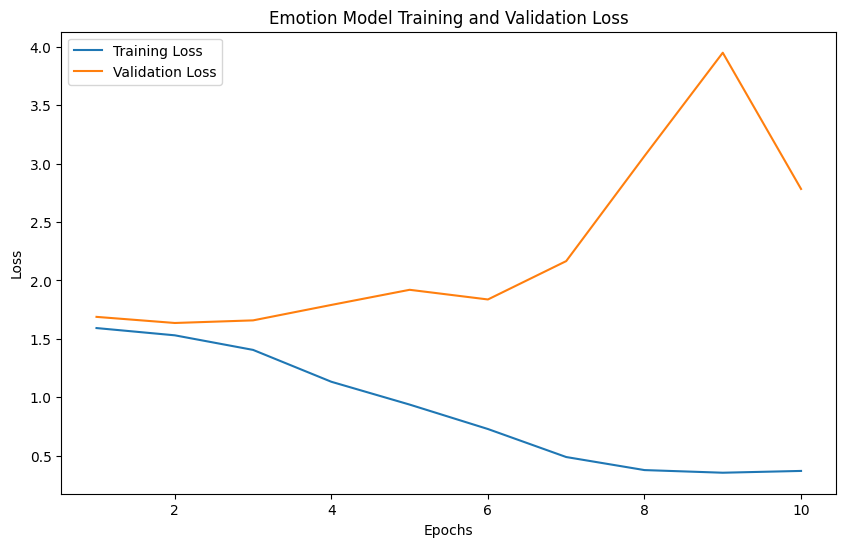

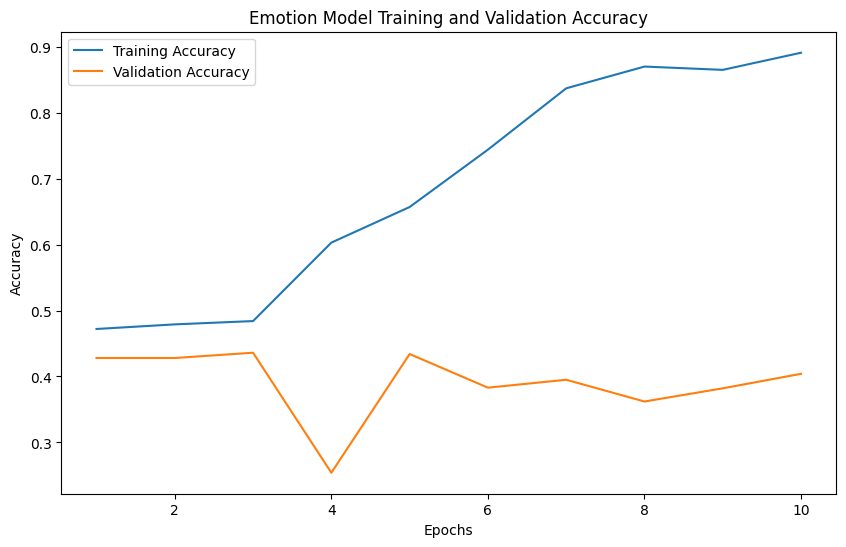

In [ ]:
plot_hist(emotion_hist,"Emotion Model")

# Further Evaluation

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

x_test = np.asarray(test_df['Word_embeddings'][:size].to_list())

# # predict sentiments
# y_test = test_df[f'Sentiment_encoded'][:size].to_numpy() # Add a word dimension

# sent_pred = np.argmax(sentiment_model.predict(x_test), axis=1)
# sent_cm = confusion_matrix(y_test, sent_pred)

# predict emotions
y_test = test_df[f'Emotion_encoded'][:size].to_numpy() # Add a word dimension

emo_pred = np.argmax(emotion_model.predict(x_test), axis=1)
emo_cm = confusion_matrix(y_test, emo_pred)

32/32 [==============================] - 40s 1s/step


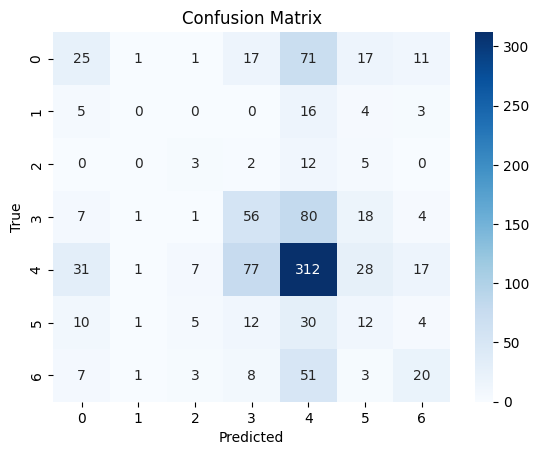

In [ ]:
# sns.heatmap(sent_cm, annot=True, fmt='d', cmap='Blues')  # Customize as needed
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# # plt.savefig("Figures/sent_confusion_mat.pdf",dpi=300)
# plt.show()

sns.heatmap(emo_cm, annot=True, fmt='d', cmap='Blues')  # Customize as needed
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig("Figures/emo_confusion_mat.pdf",dpi=300)
plt.show()

## Acc, recall,f1 etc

In [ ]:
def calculate_metrics(cm):
    """Calculates TP, FP, TN, FN for multi-class confusion matrices.

    Args:
        cm (numpy.ndarray): The confusion matrix.

    Returns:
        tuple: (TP, FP, TN, FN)
    """

    TP = np.diag(cm)  # Sum of diagonal elements (true positives)
    FP = cm.sum(axis=0) - np.diag(cm)  # Sum of each row minus diagonal (false positives)
    FN = cm.sum(axis=1) - np.diag(cm)  # Sum of each column minus diagonal (false negatives)
    TN = cm.sum() - (TP + FP + FN)  # Total elements minus TP, FP, FN (true negatives)

    return TP, FP, TN, FN

def class_metrics(metrics_df,cm):
    """Calculates accuracy, precision, recall, specificity, F1-score, FPR, FNR, and MCC for each class.

    Args:
        cm (numpy.ndarray): The multi-class confusion matrix.

    Returns:
        pandas.DataFrame: A DataFrame with the metrics for each class.
    """


    metrics_df['Accuracy'] = (metrics_df['TP'] + metrics_df['TN']) / cm.sum()
    metrics_df['Precision'] = metrics_df['TP'] / (metrics_df['TP'] + metrics_df['FP'])
    metrics_df['Recall'] = metrics_df['TP'] / (metrics_df['TP'] + metrics_df['FN'])
    metrics_df['Specificity'] = metrics_df['TN'] / (metrics_df['TN'] + metrics_df['FP'])
    metrics_df['F1-Score'] = 2 * (metrics_df['Precision'] * metrics_df['Recall']) / (metrics_df['Precision'] + metrics_df['Recall'])
    metrics_df['FPR'] = metrics_df['FP'] / (metrics_df['TN'] + metrics_df['FP'])
    metrics_df['FNR'] = metrics_df['FN'] / (metrics_df['TP'] + metrics_df['FN'])
    metrics_df['MCC'] = (metrics_df['TP'] * metrics_df['TN'] - metrics_df['FP'] * metrics_df['FN']) / np.sqrt((metrics_df['TP'] + metrics_df['FP']) * (metrics_df['TP'] + metrics_df['FN']) * (metrics_df['TN'] + metrics_df['FP']) * (metrics_df['TN'] + metrics_df['FN']))

    return metrics_df


In [ ]:
# metrics = calculate_metrics(sent_cm)
# sent_df = pd.DataFrame({"TP":metrics[0], "FP":metrics[1], "TN":metrics[2], "FN":metrics[3]},index=sentiment_mapping.keys())
# sent_df = class_metrics(sent_df,sent_cm)
# display(sent_df)

# sent_df.to_latex("Figures/sent_metrics.tex")


metrics = calculate_metrics(emo_cm)
emo_df = pd.DataFrame({"TP":metrics[0], "FP":metrics[1], "TN":metrics[2], "FN":metrics[3]},index=emotion_mapping.keys())
emo_df = class_metrics(emo_df,emo_cm)
display(emo_df)

emo_df.to_latex("Figures/emo_metrics.tex")

,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1-Score,FPR,FNR,MCC
anger,25,60,797,118,0.822,0.294118,0.174825,0.929988,0.219298,0.070012,0.825175,0.131570
disgust,0,5,967,28,0.967,0.000000,0.000000,0.994856,NaN,0.005144,1.000000,-0.012031
fear,3,17,961,19,0.964,0.150000,0.136364,0.982618,0.142857,0.017382,0.863636,0.124661
joy,56,116,717,111,0.773,0.325581,0.335329,0.860744,0.330383,0.139256,0.664671,0.193785
neutral,312,260,267,161,0.579,0.545455,0.659619,0.506641,0.597129,0.493359,0.340381,0.167767
sadness,12,75,851,62,0.863,0.137931,0.162162,0.919006,0.149068,0.080994,0.837838,0.075390
surprise,20,39,868,73,0.888,0.338983,0.215054,0.957001,0.263158,0.042999,0.784946,0.212076


<ipython-input-25-93fdde300463>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  emo_df.to_latex("Figures/emo_metrics.tex")


# ROC curves

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve , auc

def plot_roc(y_test,y_pred,num_classes,name,mapping):

  # Binarize the labels
  y_test_bin = label_binarize(y_test, classes=[i for i in range(num_classes)])

  # Compute ROC curves and AUC scores
  fpr = {}
  tpr = {}
  roc_auc = {}

  # One hot encode y_pred (0,1,2) -> ([1,0,0],[0,1,0])
  y_pred_enc = np.zeros((len(y_pred), num_classes))
  for i in range(len(y_pred)):
      y_pred_enc[i, y_pred[i]] = 1

  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_enc[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.plot(1,1)
  for i in range(num_classes):
      plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curves for {name} Model')
  plt.legend(loc='lower right')
  plt.grid()
  plt.savefig(f"Figures/{name}_roc_curve.pdf",format='pdf',dpi=300)
  plt.show()

In [ ]:
# y_test = test_df[f'Sentiment_encoded'][:size].to_numpy() # Add a word dimension
# plot_roc(y_test,sent_pred,3,"Sentiment")

y_test = test_df[f'Emotion_encoded'][:size].to_numpy() # Add a word dimension
plot_roc(y_test,emo_pred,7,"Emotion")